# Football Transfer Window Optimization

#### December 12, 2024

In [ ]:
import gamspy as gp
import gamspy.math as gpm
from gamspy import Sum, Card

import sys
import numpy as np
import pandas as pd

m = gp.Container()

## Manchester United's Transfer Strategy

## 1 - Introduction

**Manchester United** has been underperforming for the last five seasons. To address this, the club has recruited a new Manager, Ferg Hussain, who is determined to revamp the squad and restore its glory. To achieve this, he has enlisted the help of a renowned Sports Analyst to devise an **optimal strategy for improving the team** within the constraints set by the club.

The primary goal is to enhance the **overall quality (rating) of the squad** while adhering to strict financial limits. The club's funds are divided into two components: **a transfer budget and a wage budget**, spread over the next 52 weeks. In addition to financial constraints, the manager wants to ensure that the team meets **position-specific requirements and playstyle preferences**, with each player playing in their natural position.

However, the club's president has raised concerns about the **uncertainty of revenues** during the season depending upon the team's performance, which may impact the funds available for transfers. To address this, the model needs to incorporate potential fluctuations in revenue and provide a robust solution under financial uncertainty.

**Injuries** are another unavoidable aspect of football, often disrupting squad plans mid-season. The president has emphasized the importance of having a dynamic strategy to efficiently replace injured players during the winter transfer window while adhering to position-specific requirements and the club's financial constraints.

Additionally, the new manager has a specific tactical vision for the team, emphasizing:
- **Fast players on the wings** for dynamic counterattacks.
- **Left-footed options** in key positions to improve tactical flexibility.
- **Players with exceptional stamina** for relentless pressing.

Integrating these preferences into the squad-building process is a common challenge for football clubs worldwide, as transfer windows present a crucial opportunity to enhance squad quality for future success.

This project aims to develop an optimization model to build the best possible team for Manchester United, accounting for:
- Financial constraints (transfer and wage budgets).
- Tactical requirements aligned with the manager's preferences.
- The uncertainty of funds/revenue generated.
- Injury replacement strategies during the winter transfer window.

By formulating this problem as a **Mixed Integer Programming (MIP)** model, the project provides a systematic, data-driven approach to squad optimization, offering insights not only for Manchester United but also for other football clubs.

### Data

The data has been scraped from https://sofifa.com/players website

In [ ]:
i = m.addSet('i',description='observation number', records=range(0,7001))
cols = m.addSet('cols',description='index of all variables',records=["ID","Overall","Position","Value","Wage"])
pos = m.addSet('pos', description='Position of Player',records=['1','2','3','4','6','7','9','10'])
team = m.addSet('team',domain=i,description='Players in the current team',records=['1163', '6834', '5258', '2182', '3992', '257', '5133', '1911',
                                                                          '4393', '5026', '4862', '2726', '1331', '964', '6690', '2632',
                                                                          '4705', '470', '9', '4858', '6780'])

maxpos=m.addParameter('maxpos', domain=pos,description='Maximum Players in each position',records= np.array([2,2,4,2,5,2,2,2]))
posval=m.addParameter('posval', domain=pos,description='Value of each position',records= np.array([1,2,3,4,6,7,9,10]))

df = pd.read_csv("datasetfifanew.csv") #Reading the dataset
display(df.describe)
display(df.head())

#Parameters
dat = m.addParameter('dat',domain=[i,cols], records=df[['Overall','Position','Value','Wage']],
        uels_on_axes=True)
position = m.addParameter('position',domain=[i], records=df['Position'],
        uels_on_axes=True)
funds=m.addParameter('funds', domain=[],description='Funds available',records= 90000000)

<bound method NDFrame.describe of         ID             Name  Position  Age  Overall  Potential    Value  \
0        1          Iniesta         8   37       79         79  5500000   
1        2        G. Buffon         1   43       80         80  2300000   
2        3  M. Stekelenburg         1   38       76         76   825000   
3        4             Yuri         9   38       71         71   650000   
4        5     N. Penneteau         1   40       71         71   210000   
...    ...              ...       ...  ...      ...        ...      ...   
6995  6996         D. Samek         8   17       70         81  3100000   
6996  6997    Rodrigo Muniz         9   20       68         80  2900000   
6997  6998        S. Rahimi         7   25       73         76  4000000   
6998  6999        A. Marcus         9   21       68         78  2700000   
6999  7000    M. van de Ven         3   20       68         84  3000000   

       Wage  Preferred Foot  Height  ...  Positioning  Vision  Pe

,ID,Name,Position,Age,Overall,Potential,Value,Wage,Preferred Foot,Height,...,Positioning,Vision,Penalties,Composure,StandingTackle,SlidingTackle,GKDiving,GKKicking,GKReflexes,DefensiveAwareness
0,1,Iniesta,8,37,79,79,5500000,10000,1,171,...,78,90,71,89,53,50,6,6,7,68
1,2,G. Buffon,1,43,80,80,2300000,18000,1,192,...,12,50,22,70,11,11,76,70,76,13
2,3,M. Stekelenburg,1,38,76,76,825000,8000,1,197,...,12,40,23,59,15,14,75,75,74,9
3,4,Yuri,9,38,71,71,650000,5000,1,186,...,74,59,73,71,22,19,9,9,6,41
4,5,N. Penneteau,1,40,71,71,210000,7000,-1,185,...,11,53,15,56,11,11,68,66,63,21


## Existing Team

#### This is the existing team of Manchester United

In [ ]:
existing_team = set(team.records['i'].astype(int).values)
df.loc[list(existing_team), ['Name', 'Position', 'Overall']].sort_values(by='Position', ascending=True)

,Name,Position,Overall
1163,De Gea,1,84
6834,A. Onana,1,68
2182,L. Shaw,2,84
5258,N. Mazraoui,2,80
257,J. Evans,3,80
1911,H. Maguire,3,84
5133,M. de Ligt,3,85
3992,A. Diallo,3,78
4393,A. Wan-Bissaka,4,83
5026,Diogo Dalot,4,76


## Function for Visualisation

In [ ]:
spdf=None
def displayplayers():
    maxpos1=[0,2,2,4,2,0,5,2,0,2,2]
    # Extract necessary columns into arrays for faster computation
    x_records = x.records[['i', 'pos', 'level']].values
    team_indices = set(team.records['i'].values)
    df_positions = df['Position'].values

    # Separate out players with level == 1
    selected_players = x.records[x.records['level'] == 1]
    selected_player_indices = set(selected_players['i'].astype(int).values)
    selected_position_indices = selected_players['pos'].astype(int).values
    # print(selected_player_indices)

    sold_players = x.records[x.records['level']==1]
    sold_player_indices = set(sold_players['team'].astype(int).values)
    sold_position_indices = sold_players['pos'].astype(int).values
    # print(sold_player_indices)

    selected_position_indices = list(selected_position_indices)
    unsold_player_indices = set(team.records['i'].astype(int).values)
    # print(unsold_player_indices)

    # Filter out already selected positions
    final_player_indices = selected_player_indices.copy()
    for i in unsold_player_indices:
        if i not in sold_player_indices:
            final_player_indices.add(i)
    # print(final_player_indices)

    # Select and display the players
    selected_players_df = df.loc[list(final_player_indices), ['ID', 'Name', 'Position', 'Overall']]
    selected_players_df['Bought'] = ['Yes' if i in selected_player_indices else 'No' for i in final_player_indices]
    return selected_players_df.sort_values(by='Position', ascending=True)


def displayplayersexpanded():
    maxpos1=[0,2,2,4,2,0,5,2,0,2,2]
    # Extract necessary columns into arrays for faster computation
    x_records = x.records[['i', 'pos', 'level']].values
    team_indices = set(team.records['i'].values)
    df_positions = df['Position'].values

    # Separate out players with level == 1
    selected_players = x.records[x.records['level'] == 1]
    selected_player_indices = set(selected_players['i'].astype(int).values)
    selected_position_indices = selected_players['pos'].astype(int).values
    # print(selected_player_indices)

    sold_players = x.records[x.records['level']==1]
    sold_player_indices = set(sold_players['team'].astype(int).values)
    sold_position_indices = sold_players['pos'].astype(int).values
    # print(sold_player_indices)

    selected_position_indices = list(selected_position_indices)
    unsold_player_indices = set(team.records['i'].astype(int).values)
    # print(unsold_player_indices)

    # Filter out already selected positions
    final_player_indices = selected_player_indices.copy()
    for i in unsold_player_indices:
        if i not in sold_player_indices:
            final_player_indices.add(i)
    # print(final_player_indices)

    # Select and display the players
    selected_players_df = df.loc[list(final_player_indices), ['ID', 'Name', 'Position', 'Overall','Preferred Foot','Stamina','SprintSpeed']]
    selected_players_df['Bought'] = ['Yes' if i in selected_player_indices else 'No' for i in final_player_indices]
    return selected_players_df.sort_values(by='Position', ascending=True)


## 2 - Description of the Approach Used
#### Data Collection and Preparation:
The dataset scraped consisted of 7,001 players with attributes such as
- Performance Metrics: Overall ratings, potential, stamina, passing, speed, and other relevant skills.
- Financial Information: Transfer values and weekly wages.
- Tactical Attributes: Position, preferred foot, and other characteristics aligning with the manager's playstyle.
This data was processed to create input parameters for the optimization models.

#### Problem Formulation:
The squad optimization problem was modeled as a Mixed Integer Programming (MIP) problem. This allows for precise mathematical representation of decision-making variables and constraints.

**Decision Variables:**
- Binary variable: x[i,team,pos]: Buy player 'i' for 'team' at position 'pos'
- Positive variables: 'budgetx', 'wagex' : budget, and wage per week

**Objective Functions:**
- Maximizing Overall Team Rating: Focused on selecting players to maximize the improvement in the squad's overall quality.
- Balancing Ratings Across Positions: Ensured high-performing players were distributed evenly across all positions.

#### Constraints
The models included several real-world constraints:

- Base Model: Maximized the overall rating of the squad while adhering to budget and positional constraints.
- Balanced Model: Balanced ratings across positions to ensure tactical effectiveness.
- Stochastic Model: Addressed uncertainty in budget allocation and dynamically adjusted player selection.
- Playstyle constraints Model: Stochastic model integrated with the manager's playstyle preferences.
- Second Period Model: Replaced injured players mid-season while minimizing disruption to squad quality.


## 3.1 Base Model: MIP Model to Maximise Overall Rating

**Maximize
∑𝑖,𝑡𝑒𝑎𝑚,𝑝𝑜𝑠 𝑥[𝑖,𝑡𝑒𝑎𝑚,𝑝𝑜𝑠]⋅(Overall[𝑖]−Overall[𝑡𝑒𝑎𝑚])**

This MIP model aims to maximize the improvement in the team's overall quality by buying and selling players from the existing team who provide the highest net gain in ratings compared to the current team. The value of the sold player is added to the wage and transfer budget bills and can be utilised to buy players. Multiple positional constaints are enforced in this model. Financial constraints ensure that the total transfer cost stays within the allocated budget and the total wage cost remains under the wage cap. The model also splits the available funds between transfer and wage budgets.

The problem is solved using the CPLEX solver, which efficiently handles the large-scale nature of the optimization and provides a globally optimal solution within the given constraints.

In [ ]:
x = m.addVariable('x','binary',domain=[i,team,pos],description='pick')
budgetx = m.addVariable('budgetx','positive',domain=[],description='Budget')
wagex = m.addVariable('wagex','positive',domain=[],description='Wage')

choose = m.addEquation('choose',domain=[],description="Maximum number of players that can be bought")
choose[:] =   Sum((i,team,pos), x[i,team,pos]) <= 8

positionmax = m.addEquation('positionmax',domain=[pos],description="Maximum number of players for each position")
positionmax[pos] = Sum((i,team),x[i,team,pos]) <= maxpos[pos]

teammax = m.addEquation('teammax',domain=[team])
teammax[team] = Sum((i,pos),x[i,team,pos]) <= 1

positionmatch = m.addEquation('positionmatch', domain=[i,pos],description="Player picked for their own position")
positionmatch[i,pos]= Sum(team,x[i,team, pos]) * (position[i]-posval[pos]) == 0

positionmatchteam = m.addEquation('positionmatchteam', domain=[team,pos],description="Player replaced in their own position")
positionmatchteam[team,pos]= Sum(i,x[i,team, pos]) * (position[team]-posval[pos]) == 0

maxbudget = m.addEquation('maxbudget',domain=[],description="Budget constraint")
maxbudget[:] = Sum((i,team,pos),x[i,team,pos]*dat[i,'Value']) - Sum((i,team,pos),x[i,team,pos]*dat[team,'Value']) <= budgetx

maxwage = m.addEquation('maxwage',domain=[],description="Wage constraint")
maxwage[:] = Sum((i,team,pos),x[i,team,pos]*dat[i,'Wage']) - Sum((i,team,pos),x[i,team,pos]*dat[team,'Wage']) <= wagex

funds_eqn = m.addEquation('funds_eqn',domain=[],description="Funds split")
funds_eqn[:] = funds == budgetx + wagex * 52

onepos = m.addEquation('onepos',domain=[i], description='Each player can only play in one position')
onepos[i] = Sum((pos,team),x[i,team,pos]) <= 1

football = m.addModel('football',
    equations=m.getEquations(),
    problem=gp.Problem.MIP,
    sense=gp.Sense.MAX,
    objective=Sum((i,team,pos), x[i,team,pos]*((dat[i,'Overall'])-(dat[team,'Overall'])))
)

display(football.solve(solver="CPLEX",output=None))

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,81,57657,1176171,MIP,CPLEX,3.906


#### 3.1.1 Solution

In [ ]:
display(displayplayers())
print("Budget and Wage Bill Split")
display(budgetx.records)
display(wagex.records)

,ID,Name,Position,Overall,Bought
1163,1164,De Gea,1,84,No
223,224,M. Neuer,1,90,Yes
2182,2183,L. Shaw,2,84,No
5258,5259,N. Mazraoui,2,80,No
1911,1912,H. Maguire,3,84,No
113,114,Sergio Ramos,3,88,Yes
5133,5134,M. de Ligt,3,85,No
42,43,G. Chiellini,3,86,Yes
4393,4394,A. Wan-Bissaka,4,83,No
72,73,Jesus Navas,4,84,Yes


Budget and Wage Bill Split


,level,marginal,lower,upper,scale
0,55472000.0,0.0,0.0,inf,1.0


,level,marginal,lower,upper,scale
0,664000.0,0.0,0.0,inf,1.0


## 3.2 Balanced Model: Maximise rating over each position (Minimax)

**min bound, where bound >= ∑𝑖,𝑡𝑒𝑎𝑚,𝑝𝑜𝑠 𝑥[𝑖,𝑡𝑒𝑎𝑚,𝑝𝑜𝑠]⋅(Overall[𝑖]−Overall[𝑡𝑒𝑎𝑚])**

Ensure high-performing players in all positions by balancing ratings across the squad. This is modeled as a minimax problem to minimize the difference between the highest and lowest ratings across positions.

Constraints:
Position-based thresholds to balance quality evenly across the squad.

In [ ]:
maxvalue = football.objective_value
bound = m.addVariable('bound', 'free')

prating = m.addEquation('prating', domain=[i,pos])
prating[i,pos] = bound >= Sum((team), (dat[i, 'Overall']-dat[team,'Overall']) * x[i,team, pos])

balance = m.addEquation("balance", domain=[])
balance[:] = Sum(pos, Sum((i,team), (dat[i,'Overall']-dat[team,'Overall']) * x[i,team,pos])) == maxvalue

minmax = m.addModel(
    name="minmax",
    equations=m.getEquations(),
    problem=gp.Problem.MIP,
    sense=gp.Sense.MIN,
    objective=bound,
)

display(minmax.solve(solver="CPLEX",output=None))

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,20,113666,1176172,MIP,CPLEX,5.297


#### 3.2.1 Solution

In [ ]:
display(displayplayers())
print("Budget and Wage Bill Split")
display(budgetx.records)
display(wagex.records)

,ID,Name,Position,Overall,Bought
1159,1160,K. Navas,1,88,Yes
223,224,M. Neuer,1,90,Yes
2182,2183,L. Shaw,2,84,No
5258,5259,N. Mazraoui,2,80,No
257,258,J. Evans,3,80,No
1911,1912,H. Maguire,3,84,No
113,114,Sergio Ramos,3,88,Yes
42,43,G. Chiellini,3,86,Yes
4393,4394,A. Wan-Bissaka,4,83,No
72,73,Jesus Navas,4,84,Yes


Budget and Wage Bill Split


,level,marginal,lower,upper,scale
0,47516000.0,0.0,0.0,inf,1.0


,level,marginal,lower,upper,scale
0,817000.0,0.0,0.0,inf,1.0


## 3.3 Stochastic programming model - To handle uncertainty of funds; and incorporating Manager's playstyle preferences and randomness of injuries to players

**Summer Transfer Window Model:**

Maximize
∑𝑖,𝑡𝑒𝑎𝑚,𝑝𝑜𝑠 𝑥[𝑖,𝑡𝑒𝑎𝑚,𝑝𝑜𝑠]⋅(Overall[𝑖]−Overall[𝑡𝑒𝑎𝑚])

This MIP model leverages the principles of stochastic programming and constraint logic programming to optimize the selection and retention of football players for a team, considering tactical playstyles, financial uncertainties, and squad balance. The model incorporates uncertainty in financial resources by representing potential future scenarios of the team's performance(e.g., winning a cup, relegation, top 10 finish, etc.).

Each scenario is associated with a probability (p) and an expected funds allocation (funds).
p∈R : Probability of each scenario 𝑠𝑘, where ∑pk = 1
The funds are split into two: fixed and variable, the variable funds change according to the scenario.
The model dynamically adjusts the transfer (budgetx) and wage budgets (wagex) based on these scenarios to maximize squad improvement under uncertain future conditions.

The manager is very keen on playing a counter attacking style. So relevant playstyle-based constraints such as high stamina for intense pressing, fast wide players for quick counters, and left footed-players are enforced for both new and retained players.


**Winter Transfer Window Model:**

After recruting new players in the summer transfer window, injuries can be random during the course of a season. Winter transfer wibdows are often used toSo, this MIP model emphasises on replacing these injured players which are randomly determined(much like real-life where injuries can be very random).

### Summer Transfer Window

In [ ]:
m = gp.Container()
i = m.addSet('i',description='observation number', records=range(0,7001))
cols = m.addSet('cols',description='index of all variables',records=[
    'ID', 'Position', 'Age', 'Overall', 'Potential', 'Value', 'Wage', 'Preferred Foot',
    'Height', 'Crossing', 'Finishing', 'ShortPassing', 'Dribbling', 'FKAccuracy', 'LongPassing',
    'Acceleration', 'SprintSpeed', 'Agility','Stamina', 'LongShots', 'Interceptions', 'Positioning',
    'Vision', 'Penalties', 'Composure', 'StandingTackle', 'SlidingTackle', 'GKDiving',
    'GKKicking', 'GKReflexes', 'DefensiveAwareness'
])
dat = m.addParameter('dat',domain=[i,cols],
 records = df[[
    'ID', 'Position', 'Age', 'Overall', 'Potential', 'Value', 'Wage', 'Preferred Foot',
    'Height', 'Crossing', 'Finishing', 'ShortPassing', 'Dribbling', 'FKAccuracy', 'LongPassing',
    'Acceleration', 'SprintSpeed', 'Agility', 'Stamina','LongShots', 'Interceptions', 'Positioning',
    'Vision', 'Penalties', 'Composure', 'StandingTackle', 'SlidingTackle', 'GKDiving',
    'GKKicking', 'GKReflexes', 'DefensiveAwareness'
]],uels_on_axes=True)

pos = m.addSet('pos', description='Position of Player',records=['1','2','3','4','6','7','9','10'])
team = m.addSet('team',domain=i,description='Position of Player',records=['1163', '6834', '5258', '2182', '3992', '257', '5133', '1911',
                                                                          '4393', '5026', '4862', '2726', '1331', '964', '6690', '2632',
                                                                          '4705', '470', '9', '4858', '6780'])

maxpos=m.addParameter('maxpos', domain=pos,description='Maximum Players in each position',records= np.array([2,2,4,2,5,2,2,2]))
posval=m.addParameter('posval', domain=pos,description='Maximum Players in each position',records= np.array([1,2,3,4,6,7,9,10]))

df = pd.read_csv("datasetfifanew.csv")

# dat = m.addParameter('dat',domain=[i,cols],
#     records=df[['ID', 'Overall','Position','Value','Wage']],
#         uels_on_axes=True)

position = m.addParameter('position',domain=[i],
    records=df['Position'],
        uels_on_axes=True)

#Caps
s = gp.Set(m,'s',records=['Relegation', 'Top 10', 'Top 4','Table top','Preseason Cup Winners'],description='scenarios')
p = gp.Parameter(m,'p',domain=s,description='probability',records=np.array([1/20,7/20,2/10,3/10,1/10]))

fixedfunds=m.addParameter('fixedfunds', domain=[],description='Maximum funds',records=30000000) #Portion of Total Funds that aren't affected
variablefunds = np.array([90000000]) #Portion of Total Funds that can vary according to scenarios

funds=m.addParameter('funds', domain=[s],description='Maximum funds',records=np.stack((0.2*variablefunds, 0.7*variablefunds, 1*variablefunds,1.1*variablefunds,variablefunds+50000000),axis=0))

x = m.addVariable('x','binary',domain=[i,team,pos],description='Pick Player')
budgetx = m.addVariable('budgetx','positive',domain=[s],description='Budget')
wagex = m.addVariable('wagex','positive',domain=[s],description='Wage')

choose = m.addEquation('choose',domain=[])
choose[:] =   Sum((i,team,pos), x[i,team,pos]) <= 8

positionmax = m.addEquation('positionmax',domain=[pos])
positionmax[pos] = Sum((i,team),x[i,team,pos]) <= maxpos[pos]

teammax = m.addEquation('teammax',domain=[team])
teammax[team] = Sum((i,pos),x[i,team,pos]) <= 1

positionmatch = m.addEquation('positionmatch', domain=[i,pos])
positionmatch[i,pos]= Sum(team,x[i,team, pos]) * position[i] == posval[pos] * Sum(team,x[i,team, pos])

positionmatchteam = m.addEquation('positionmatchteam', domain=[team,pos])
positionmatchteam[team,pos]= Sum(i,x[i,team, pos]) * (position[team]-posval[pos]) == 0

maxbudget = m.addEquation('maxbudget',domain=[])
maxbudget[:] = Sum((i,team,pos),x[i,team,pos]*dat[i,'Value']) - Sum((i,team,pos),x[i,team,pos]*dat[team,'Value']) <= Sum(s,p[s]*budgetx[s])

maxwage = m.addEquation('maxwage',domain=[])
maxwage[:] = Sum((i,team,pos),x[i,team,pos]*dat[i,'Wage']) - Sum((i,team,pos),x[i,team,pos]*dat[team,'Wage']) <= Sum(s,p[s]*wagex[s])

funds_eqn = m.addEquation('funds_eqn',domain=[s])
funds_eqn[s] = funds+fixedfunds == budgetx[s] + wagex[s] * 52

onepos = m.addEquation('onepos',domain=[i])
onepos[i] = Sum((pos,team),x[i,team,pos]) <= 1

# Existing players that remain in the team
team_remaining = m.addVariable('team_remaining', 'binary', domain=[team], description='Existing players not sold')

# Constraint to determine if a player is part of the final team (either bought or retained)
final_team = m.addEquation('final_team', domain=[team])
final_team[team] = Sum((i,pos),x[i, team, pos]) + team_remaining[team] == 1

# Stamina requirement for high-press playstyle
staminareq = m.addParameter('staminareq',domain=[pos],records=np.array(['0','70','70','70','0','70','0','70']))
highpress = m.addEquation('highpress', domain=[team, pos])
highpress[team, pos] = (
    Sum(i, x[i, team, pos] * (dat[i, 'Stamina'] - staminareq[pos])) +
    team_remaining[team] * (dat[team, 'Stamina'] - staminareq[pos])) >= 0

#Pacy Wings
pacereq = m.addParameter('pacereq',domain=[pos],records=np.array(['0','70','0','70','0','70','0','70']))
pacywings = m.addEquation('pacywings', domain=[i,team,pos])
pacywings[i,team,pos] = x[i,team,pos]*(dat[i,'SprintSpeed']-pacereq[pos]) >=0

# #Atleast one left footed midfielder
leftfootedmid = m.addEquation('leftfootedmid', domain=[])
leftfootedmid[:] = Sum((i,team),x[i,team,'6']*(dat[i,'Preferred Foot'])) + Sum(team.where[dat[team,'Position']=='6'],team_remaining[team]*(dat[team,'Preferred Foot'])) <= 3

# #Atleast one left footed centre back
leftfootedcb = m.addEquation('leftfootedcb', domain=[])
leftfootedcb[:] = Sum((i,team),x[i,team,'3']*(dat[i,'Preferred Foot'])) + Sum(team.where[dat[team,'Position']=='3'],team_remaining[team]*(dat[team,'Preferred Foot'])) <= 2

footballstoc = m.addModel('footballstoc',
    equations=m.getEquations(),
    problem=gp.Problem.MIP,
    sense=gp.Sense.MAX,
    objective=Sum((i,team,pos), x[i,team,pos]*(dat[i,'Overall']-dat[team,'Overall']))
)

display(footballstoc.solve(solver="CPLEX",output=None))

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,68,1215540,1176200,MIP,CPLEX,5.204


#### 3.3.1 Solution

In [ ]:
display(displayplayersexpanded())
print("Budget and Wage Bill Split")
display(budgetx.records)
display(wagex.records)

,ID,Name,Position,Overall,Preferred Foot,Stamina,SprintSpeed,Bought
1159,1160,K. Navas,1,88,1,39,53,Yes
223,224,M. Neuer,1,90,1,43,60,Yes
2182,2183,L. Shaw,2,84,-1,80,81,No
5258,5259,N. Mazraoui,2,80,1,82,83,No
5133,5134,M. de Ligt,3,85,1,75,75,No
42,43,G. Chiellini,3,86,-1,71,69,Yes
1911,1912,H. Maguire,3,84,1,82,53,No
113,114,Sergio Ramos,3,88,1,78,69,Yes
5026,5027,Diogo Dalot,4,76,1,74,80,No
4393,4394,A. Wan-Bissaka,4,83,1,81,88,No


Budget and Wage Bill Split


,s,level,marginal,lower,upper,scale
0,Relegation,4.800000e+07,0.0,0.0,inf,1.0
1,Top 10,3.428571e+06,0.0,0.0,inf,1.0
2,Top 4,1.200000e+08,0.0,0.0,inf,1.0
3,Table top,1.290000e+08,0.0,0.0,inf,1.0
4,Preseason Cup Winners,1.700000e+08,0.0,0.0,inf,1.0


,s,level,marginal,lower,upper,scale
0,Relegation,0.000000e+00,-0.0,0.0,inf,1.0
1,Top 10,1.722527e+06,0.0,0.0,inf,1.0
2,Top 4,0.000000e+00,-0.0,0.0,inf,1.0
3,Table top,0.000000e+00,-0.0,0.0,inf,1.0
4,Preseason Cup Winners,0.000000e+00,-0.0,0.0,inf,1.0


In [ ]:
spdf=displayplayers();
maxpos = {1: 1, 2: 1, 3: 2, 4: 1, 6: 3, 7: 1, 9: 1, 10: 1}
# Extract necessary columns into arrays for faster computation
# Initialize an empty DataFrame for the final selected players
final_selected_players = pd.DataFrame()

# Iterate over positions and get top players for each
for pos1, count in maxpos.items():
    top_players = spdf[spdf['Position'] == pos1].nlargest(count, 'Overall')
    final_selected_players = pd.concat([final_selected_players, top_players], ignore_index=True)

# Sort the final players by position for better readability
final_selected_players = final_selected_players.sort_values(by='Position').reset_index(drop=True);

### Winter Transfer Window

Unfortunately, the squad has been struck with injuries. We have to buy the replacements for those players.

In [ ]:
newteam=list(spdf['ID']-1)

#Updating the team
# Generate an array of 21 elements with a probability of 0.12 for 1, and 0.88 for 0
injured = np.random.choice([0, 1], size=21, p=[0.9, 0.1])
numinj = sum(injured)
# selected_players_df = df.loc[injured, ['ID', 'Name', 'Position', 'Overall']]

print("Number of injured players:",numinj)

# Extract players from newteam who are injured
injured_players = [newteam[i] for i in range(len(injured)) if injured[i] == 1]
print(df.loc[injured_players, ['ID', 'Name', 'Position', 'Overall']])

m = gp.Container()
i = m.addSet('i',description='observation number', records=range(0,7001))
cols = m.addSet('cols',description='index of all variables',records=["ID","Name","Overall","Position","Value","Wage"])
pos = m.addSet('pos', description='Position of Player',records=['1','2','3','4','6','7','9','10'])
team = m.addSet('team',domain=i,description='Position of Player',records=newteam)

isinjured=m.addParameter('isinjured',domain=team,records=np.array(injured))
injuredcount=m.addParameter('injuredcount',domain=[],records=np.array(numinj))

maxpos=m.addParameter('maxpos', domain=pos,description='Maximum Players in each position',records= np.array([2,2,4,2,5,2,2,2]))
posval=m.addParameter('posval', domain=pos,description='Maximum Players in each position',records= np.array([1,2,3,4,6,7,9,10]))

df = pd.read_csv("datasetfifanew.csv")

dat = m.addParameter('dat',domain=[i,cols],
    records=df[['ID', 'Overall','Position','Value','Wage']],
        uels_on_axes=True)

position = m.addParameter('position',domain=[i],
    records=df['Position'],
        uels_on_axes=True)

#Caps
s = gp.Set(m,'s',records=['Recession', 'Loss', 'Ideal','Profit','New Sponsor'])

p = gp.Parameter(m,'p',domain=s,description='probability',records=np.array([1/20,7/20,2/10,3/10,1/10]))
avgfunds = np.array([1000000])

funds=m.addParameter('funds', domain=[s],description='Maximum funds',records=np.stack((0.2*avgfunds, 0.7*avgfunds, 1*avgfunds,1.1*avgfunds,avgfunds+50000000),axis=0))

x = m.addVariable('x','binary',domain=[i,team,pos],description='pick')
budgetx = m.addVariable('budgetx','positive',domain=[s],description='Budget')
wagex = m.addVariable('wagex','positive',domain=[s],description='Wage')

choose = m.addEquation('choose',domain=[])
choose[:] =   Sum((i,team,pos), x[i,team,pos]) == injuredcount

positionmax = m.addEquation('positionmax',domain=[pos])
positionmax[pos] = Sum((i,team),x[i,team,pos]) <= maxpos[pos]

teammax = m.addEquation('teammax',domain=[team])
teammax[team] = Sum((i,pos),x[i,team,pos]) <= 1

positionmatch = m.addEquation('positionmatch', domain=[i,pos])
positionmatch[i,pos]= Sum(team,x[i,team, pos]) * position[i] == posval[pos] * Sum(team,x[i,team, pos])

positionmatchteam = m.addEquation('positionmatchteam', domain=[team,pos])
positionmatchteam[team,pos]= Sum(i,x[i,team, pos]) * (position[team]-posval[pos]) == 0

maxbudget = m.addEquation('maxbudget',domain=[])
maxbudget[:] = Sum((i,team,pos),x[i,team,pos]*dat[i,'Value'])  <= Sum(s,p[s]*budgetx[s])

maxwage = m.addEquation('maxwage',domain=[])
maxwage[:] = Sum((i,team,pos),x[i,team,pos]*dat[i,'Wage'])  <= Sum(s,p[s]*wagex[s])

funds_eqn = m.addEquation('funds_eqn',domain=[s])
funds_eqn[s] = funds == budgetx[s] + wagex[s] * 26

onepos = m.addEquation('onepos',domain=[i])
onepos[i] = Sum((pos,team),x[i,team,pos]) <= 1

replacements = m.addEquation('replacements', domain=[team])
replacements[team] =   Sum((i,pos), x[i,team,pos]) == isinjured[team]

footballstoc = m.addModel('footballstoc',
    equations=m.getEquations(),
    problem=gp.Problem.MIP,
    sense=gp.Sense.MAX,
    objective=Sum((i,team,pos), x[i,team,pos]*(dat[i,'Overall']-dat[team,'Overall']))
)

display(footballstoc.solve(solver="CPLEX",output=None))

Number of injured players: 4
        ID               Name  Position  Overall
1159  1160           K. Navas         1       88
3926  3927             Merino         6       83
6        7  Cristiano Ronaldo         9       91
4858  4859          J. Sancho        10       87


,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,-51,57682,1176179,MIP,CPLEX,2.5


#### 3.3.2 Solution

In [ ]:
display(displayplayers())
print("Budget and Wage Bill Split")
display(budgetx.records)
display(wagex.records)

,ID,Name,Position,Overall,Bought
1120,1121,D. Subašić,1,76,Yes
223,224,M. Neuer,1,90,No
2182,2183,L. Shaw,2,84,No
5258,5259,N. Mazraoui,2,80,No
5133,5134,M. de Ligt,3,85,No
1911,1912,H. Maguire,3,84,No
113,114,Sergio Ramos,3,88,No
42,43,G. Chiellini,3,86,No
5026,5027,Diogo Dalot,4,76,No
4393,4394,A. Wan-Bissaka,4,83,No


Budget and Wage Bill Split


,s,level,marginal,lower,upper,scale
0,Recession,200000.0,0.0,0.0,inf,1.0
1,Loss,700000.0,0.0,0.0,inf,1.0
2,Ideal,1000000.0,0.0,0.0,inf,1.0
3,Profit,1100000.0,0.0,0.0,inf,1.0
4,New Sponsor,44900000.0,0.0,0.0,inf,1.0


,s,level,marginal,lower,upper,scale
0,Recession,0.000000,-0.0,0.0,inf,1.0
1,Loss,0.000000,-0.0,0.0,inf,1.0
2,Ideal,0.000000,-0.0,0.0,inf,1.0
3,Profit,0.000000,-0.0,0.0,inf,1.0
4,New Sponsor,234615.384615,0.0,0.0,inf,1.0


## 4. Visualisation and Sensitivity Analysis

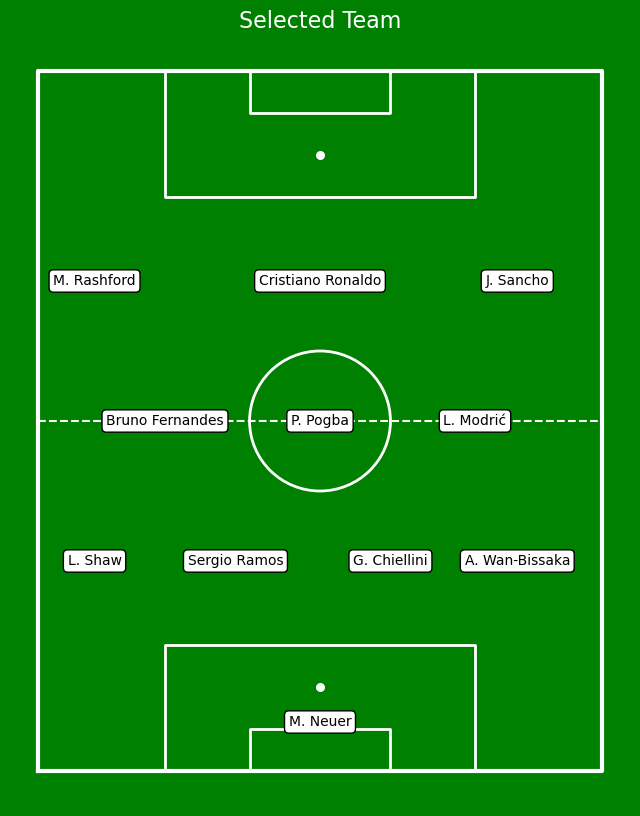

In [ ]:
import matplotlib.pyplot as plt

# Define football field dimensions
field_length = 100  # Vertical field length
field_width = 80    # Horizontal field width

# Function to generate dynamic coordinates based on DataFrame index
def generate_dynamic_coords(df, base_coords, position_offset=12):

    dynamic_coords = {}
    position_counters = {}  # Track how many players are already placed in a position

    for idx, row in df.iterrows():
        position = row['Position']

        # Get the base coordinates for the position
        base_x, base_y = base_coords.get(position, (field_width / 2, field_length / 2))

        # Track the number of players already placed for this position
        if position not in position_counters:
            position_counters[position] = 0

        # Increase horizontal gap for specific positions (e.g., center backs, midfielders)
        if position in [3, 6]:  # Adjust for center backs and midfielders
            offset_x = (position_counters[position] % 3) * (position_offset + 10) - position_offset
            offset_y = (position_counters[position] // 3) * position_offset
        else:  # Default offset for other positions
            offset_x = (position_counters[position] % 3) * position_offset - position_offset
            offset_y = (position_counters[position] // 3) * position_offset

        # Update dynamic coordinates for this player
        dynamic_coords[idx] = (base_x + offset_x, base_y + offset_y)

        # Increment the counter for this position
        position_counters[position] += 1

    return dynamic_coords

# Base position mapping for standard player positions
base_position_coords = {
    1: (52, 7),   # Goalkeeper
    2: (20, 30),  # Left Back
    3: (40, 30),  # Center Backs
    4: (80, 30),  # Right Back
    6: (30, 50),  # Central Midfielders
    7: (20, 70),  # Left Winger
    9: (52, 70), # Striker
    10: (80,70)   # Right Winger
}

# Function to visualize the football field
def plot_football_field():
    plt.figure(figsize=(8, 10), facecolor="green")
    plt.gca().set_facecolor("white")

    # Field boundaries
    plt.plot([0, 0, field_width, field_width, 0], [0, field_length, field_length, 0, 0], color="white", linewidth=3)
    plt.plot([0, field_width], [field_length / 2, field_length / 2], color="white", linestyle="--")

    # Penalty areas (18-yard box dimensions)
    penalty_area_length = 18  # Depth of the penalty area
    penalty_area_width = 44   # Width of the penalty area

    plt.plot([field_width / 2 - penalty_area_width / 2, field_width / 2 + penalty_area_width / 2,
              field_width / 2 + penalty_area_width / 2, field_width / 2 - penalty_area_width / 2,
              field_width / 2 - penalty_area_width / 2],
             [0, 0, penalty_area_length, penalty_area_length, 0],
             color="white", linewidth=2)

    plt.plot([field_width / 2 - penalty_area_width / 2, field_width / 2 + penalty_area_width / 2,
              field_width / 2 + penalty_area_width / 2, field_width / 2 - penalty_area_width / 2,
              field_width / 2 - penalty_area_width / 2],
             [field_length, field_length, field_length - penalty_area_length, field_length - penalty_area_length,
              field_length],
             color="white", linewidth=2)

    # 6-yard box
    goal_area_length = 6
    goal_area_width = 20

    plt.plot([field_width / 2 - goal_area_width / 2, field_width / 2 + goal_area_width / 2,
              field_width / 2 + goal_area_width / 2, field_width / 2 - goal_area_width / 2,
              field_width / 2 - goal_area_width / 2],
             [0, 0, goal_area_length, goal_area_length, 0],
             color="white", linewidth=2)
    plt.plot([field_width / 2 - goal_area_width / 2, field_width / 2 + goal_area_width / 2,
              field_width / 2 + goal_area_width / 2, field_width / 2 - goal_area_width / 2,
              field_width / 2 - goal_area_width / 2],
             [field_length, field_length, field_length - goal_area_length, field_length - goal_area_length,
              field_length],
             color="white", linewidth=2)

    # Center circle
    center_circle = plt.Circle((field_width / 2, field_length / 2), 10, color="white", fill=False, linewidth=2)
    plt.gca().add_patch(center_circle)

    # Penalty spots
    plt.scatter([field_width / 2], [12], color="white", s=30)
    plt.scatter([field_width / 2], [field_length - 12], color="white", s=30)

    # Goal posts
    plt.plot([field_width / 2 - 3.66, field_width / 2 + 3.66], [0, 0], color="white", linewidth=2)
    plt.plot([field_width / 2 - 3.66, field_width / 2 + 3.66], [field_length, field_length], color="white", linewidth=2)

    plt.title("Selected Team", fontsize=16,color="white")
    plt.axis("off")


# Function to plot players dynamically from DataFrame
def plot_players_from_df(df, dynamic_coords):
    for idx, row in df.iterrows():
        name = row['Name']
        coord = dynamic_coords.get(idx, (0, 0))  # Default to (0, 0) if no coordinates are found
        plt.text(coord[0], coord[1], name, fontsize=10, color="black", ha='center', va='center',
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.3"))

# Main function to visualize the football field and players
def visualize_dynamic_football_field(df):
    # Generate dynamic coordinates for players
    dynamic_coords = generate_dynamic_coords(df, base_position_coords)

    # Plot the field and players
    plot_football_field()
    plot_players_from_df(df, dynamic_coords)
    plt.show()

visualize_dynamic_football_field(final_selected_players)


## Pareto curve b/w Funds and Rating

In [ ]:
#  solret = []
#  soldev = []
#  # Calculate values on Pareto curve here
#  for r in range(50000000, 350000000, 5000000):
#      funds[:] = r
#      football.solve()
#      if football.status in [
#          gp.ModelStatus.OptimalGlobal,
#          gp.ModelStatus.OptimalLocal]:
#          solret.append(r)
#          soldev.append(football.objective_value)
#      else:
#          break

# %matplotlib inline
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize=(8,6))
# ax.set_title("Pareto tradeoff: Budget vs Rating")
# ax.set_xlabel("Budget")
# ax.set_ylabel("Rating")
# ax.plot(solret,soldev,"b.-");

##### I have pasted a saved output that was computed earlier as it took over 1 hour to execute!
(![pareto.png](attachment:b3768893-e8ea-4518-9971-6c482bb5df68.png)

## 5 - Conclusion

The **simple MIP model** which focused on maximising the rating given positional and financial constraints brought a difference of rating in the squad. It led to an **objective value of 80**, indicating the **total increase in the rating** from existing to the new squad.

The **second MIP model** where we aimed to see a **more balanced team**, led to a different composition of the team. For example, the goalkeepers average rating was pushed up from an average rating of **86 to 89**, making it more balanced over all positions.

The **final model incorporated stochastic programming** with an uncertainity of funds and also had enforced manager's playstyle preferences into the model. In the **Summer transfer window**, there was a **huge drop in the objective value, from 80(in the first model) to 68**, which is obvious because of the **large number of constraints**. But the final team consisted of exactly what the manager wanted in form of atleast one left footed centre back and a midfielder and also players with high stamina and pace to match his playstyle. The transfer and wage splits differed from one scenario to another to accomodate the uncertainity of funds.

After **randomly generating data for injuries**, we can see that 4 players were injured. The **Winter transfer window** model replaced these players by other players from the transfer market given a budget constraint. The **-51 objective value** of the model indicates the the **change in the total rating of players injured.** The players bought can be seen in the output in the column - 'Bought'. Navas, Merino, Ronaldo and Sancho were replaced by Subasic, Larsson, Boselli and Fuenzalida.

As seen on the **Pareto curve**, there is clear **increase in rating** of the squad, given an **increase in the funds** for transfer and budget.

## 6 - Further Readings/ Extension

This model can be further extended to improve its applicability and robustness in real-world scenarios. Potential extensions and areas for further research include:

1. **Adapting Player Ratings for Out-of-Position Play:**
Currently, the model restricts players to their natural positions. An extension could allow players to be selected for positions outside their primary role by:
Introducing a penalty or adjustment to their rating based on their suitability for the new position.
Utilizing a matrix or scoring system to estimate performance in alternate roles (e.g., a center-back playing as a defensive midfielder).

2. **Multi-Season Optimization:**
The current model focuses on optimizing the squad for a single season. A multi-season approach could:
Include projections for player growth (potential) or decline (age-related factors).
Factor in contract durations, resale values, and future budget implications.
Develop strategies for long-term planning, such as academy player development or phasing out aging players.

3. **More constraints:**
Due to the vast dataset and a humongous number of equations, and limited computational resources, more constraints and dat couldn't be added to the model. The computation time was very large. Given better resources, a large number of various constraints and data can be integrated into the model making it a very powerful model for optmizing the strategies of a football transfer window.

4. **Model that simulates a transfer market as a whole**
A model that optimises all of the clubs together and incorporate transfer between them such that every club in the league has a balanced rating.
